## Physical Uncolnable Functions Dataset: Predicting circuit output given challange input bits

Installing some packages.

In [29]:
!pip install pydot

In [36]:
!pip install pydotplus

     |████████████████████████████████| 286kB 27.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [37]:
!pip install graphviz

Importing all necessary modules.

In [32]:
import pydot

In [33]:
import tensorflow as tf
tf.__version__

'1.13.1'

In [46]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import Image

In [42]:
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import keras
keras.utils.vis_utils.pydot = pydot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

This cell will load the dataset that is stored on IBM Cloud. I've set the content to be hidden since it's
using my credentials.

In [5]:
# The code was removed by Watson Studio for sharing.

10.025636434555054 seconds


This cell loads circuit responses directly from the author's GitHub page.

In [6]:
!wget https://raw.githubusercontent.com/Praneshss/Modeling_of_APUF_Compositions/master/64bit/1Million/all_responses/6resp_XOR_APUF_chal_64_1Million.csv

--2020-05-14 18:01:42--  https://raw.githubusercontent.com/Praneshss/Modeling_of_APUF_Compositions/master/64bit/1Million/all_responses/6resp_XOR_APUF_chal_64_1Million.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2000000 (1.9M) [text/plain]
Saving to: ‘6resp_XOR_APUF_chal_64_1Million.csv’

100%[======================================>] 2,000,000   --.-K/s   in 0.04s   

2020-05-14 18:01:43 (47.1 MB/s) - ‘6resp_XOR_APUF_chal_64_1Million.csv’ saved [2000000/2000000]



In [7]:
y = pd.read_csv("6resp_XOR_APUF_chal_64_1Million.csv", header=None)

Dataset consists of 64 parity bits (columns 1:65) which can only take the values -1 or 1.

In [8]:
df_data_1.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,1,1,1,-1,-1,1,-1,1,-1,-1,...,-1,-1,1,-1,1,-1,-1,1,1,0
1,1,1,1,1,-1,1,1,1,1,1,...,1,-1,-1,-1,-1,-1,-1,-1,0,0
2,1,-1,1,1,-1,1,-1,1,-1,-1,...,1,1,1,1,1,-1,1,-1,1,1
3,1,1,1,1,-1,-1,1,-1,-1,1,...,-1,-1,1,-1,1,-1,1,1,0,1
4,1,1,-1,-1,1,-1,1,-1,-1,-1,...,1,-1,1,-1,-1,-1,-1,-1,0,0


Since there are only 2 classes (XOR output) y contains only 2 distinct values.

In [9]:
y.head()

,0
0,0
1,1
2,0
3,0
4,0


In [10]:
X = df_data_1.iloc[:, 1:65]
y = y.values

You can see that the classes are evenly separated, so no problems there.

Text(0.5, 1.0, 'Class distribution')

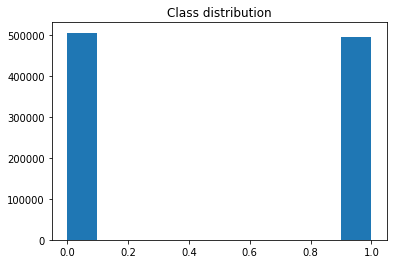

In [11]:
plt.hist(y)
plt.title("Class distribution")

In [12]:
X = X.values

In [13]:
X[0]

array([ 1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1,
        1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,
        1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1,
        1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1])

Map each entry of y to a one hot vector bc we're using Categorical Crossentropy loss and we'll need one neuron for each class.

In [14]:
y = to_categorical(y)

In [15]:
y[:3]

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Split the dataset into train and test set with 25% going to test set.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [17]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [18]:
X_train.shape, y_train.shape

((750000, 64), (750000, 2))

In [19]:
X_test.shape, y_test.shape

((250000, 64), (250000, 2))

In [20]:
input_dim = X_train.shape[-1]
input_dim

64

Definition of the first model. Layer sizes were chosen manually such as to give a fairly good accuracy (almost 99%) and to obtain a relatively short time for training.

In [21]:
def get_model1():
    # model = Sequential()
    # model.add(Dense(512, activation='relu', input_dim=input_dim))
    # model.add(Dropout(rate=0.2))
    # model.add(Dense(512, activation='relu', input_dim=input_dim))
    # model.add(Dropout(rate=0.2))
    # model.add(Dense(256, activation='relu', input_dim=input_dim))
    # model.add(Dropout(rate=0.2))
    # model.add(Dense(2, activation='softmax'))
    # optim = Adam(lr=0.01)
    # model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

    inpt = Input(shape=(input_dim,))
    hl = Dense(256, activation='relu')(inpt)
    hl = Dense(256, activation='relu')(hl)
    hl = Dense(128, activation='relu')(hl)
    hl = Dense(32, activation='relu')(hl)
    outpt = Dense(2, activation='softmax')(hl)
    model = Model(inputs=inpt, outputs=outpt)
    optim = Adam(lr=1/1000)
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model1 = get_model1()
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 119,522
Trainable params: 119,522
Non-trainable params: 

Perform training on the first model.

In [23]:
model1.fit(x=X_train, y=y_train, 
          batch_size=1000, epochs=2, verbose=1,
         validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 750000 samples, validate on 250000 samples
Epoch 1/2
750000/750000 [==============================] - 67s 89us/step - loss: 0.0533 - acc: 0.9761 - val_loss: 0.0291 - val_acc: 0.9871
Epoch 2/2
750000/750000 [==============================] - 63s 84us/step - loss: 0.0225 - acc: 0.9903 - val_loss: 0.0245 - val_acc: 0.9894


As you can see the model takes about 2 minutes to train, giving 99% accuracy on train and 98.9% accuracy on test.

In [24]:
# accuracy for first 10 000 samples from test set
n_test = 10000
sum(np.argmax(model1.predict(X_test[:n_test]),1) == np.argmax(y_test[:n_test],1)) / n_test

0.9891

Definition of the second model. Here we emply the knowledge we have about the physical system and build 6 similar NNs, that will work in parallel, their results being concatenated and fed to the output layer.

In [25]:
def get_model2():
    inpt = Input(shape=(input_dim,))
    
    # 6 XORs -> 6 NNs
    hl1 = Dense(128, activation='relu')(inpt)
    hl1 = Dense(128, activation='relu')(hl1)
    hl1 = Dense(32, activation='relu')(hl1)
    hl1 = Dense(1, activation='sigmoid')(hl1)
    
    hl2 = Dense(128, activation='relu')(inpt)
    hl2 = Dense(128, activation='relu')(hl2)
    hl2 = Dense(32, activation='relu')(hl2)
    hl2 = Dense(1, activation='sigmoid')(hl2)
    
    hl3 = Dense(128, activation='relu')(inpt)
    hl3 = Dense(128, activation='relu')(hl3)
    hl3 = Dense(32, activation='relu')(hl3)
    hl3 = Dense(1, activation='sigmoid')(hl3)
    
    hl4 = Dense(128, activation='relu')(inpt)
    hl4 = Dense(128, activation='relu')(hl4)
    hl4 = Dense(32, activation='relu')(hl4)
    hl4 = Dense(1, activation='sigmoid')(hl4)
    
    hl5 = Dense(128, activation='relu')(inpt)
    hl5 = Dense(128, activation='relu')(hl5)
    hl5 = Dense(32, activation='relu')(hl5)
    hl5 = Dense(1, activation='sigmoid')(hl5)
    
    hl6 = Dense(128, activation='relu')(inpt)
    hl6 = Dense(128, activation='relu')(hl6)
    hl6 = Dense(32, activation='relu')(hl6)
    hl6 = Dense(1, activation='sigmoid')(hl6)
    
    hl = Concatenate()([hl1, hl2, hl3, hl4, hl5, hl6])
    outpt = Dense(2, activation='softmax')(hl)
    
    model = Model(inputs=inpt, outputs=outpt)
    optim = Adam(lr=1/1000)
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model2 = get_model2()
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          8320        input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          8320        input_2[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 128)          8320        input_2[0][0]                    
__________________________________________________________________________________________________
dense_18 (

It has more parameters than the first one, so we expect an increase in the training time. Let's print a graph for this model, so we can have a better idea about this architecture.

In [44]:
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)

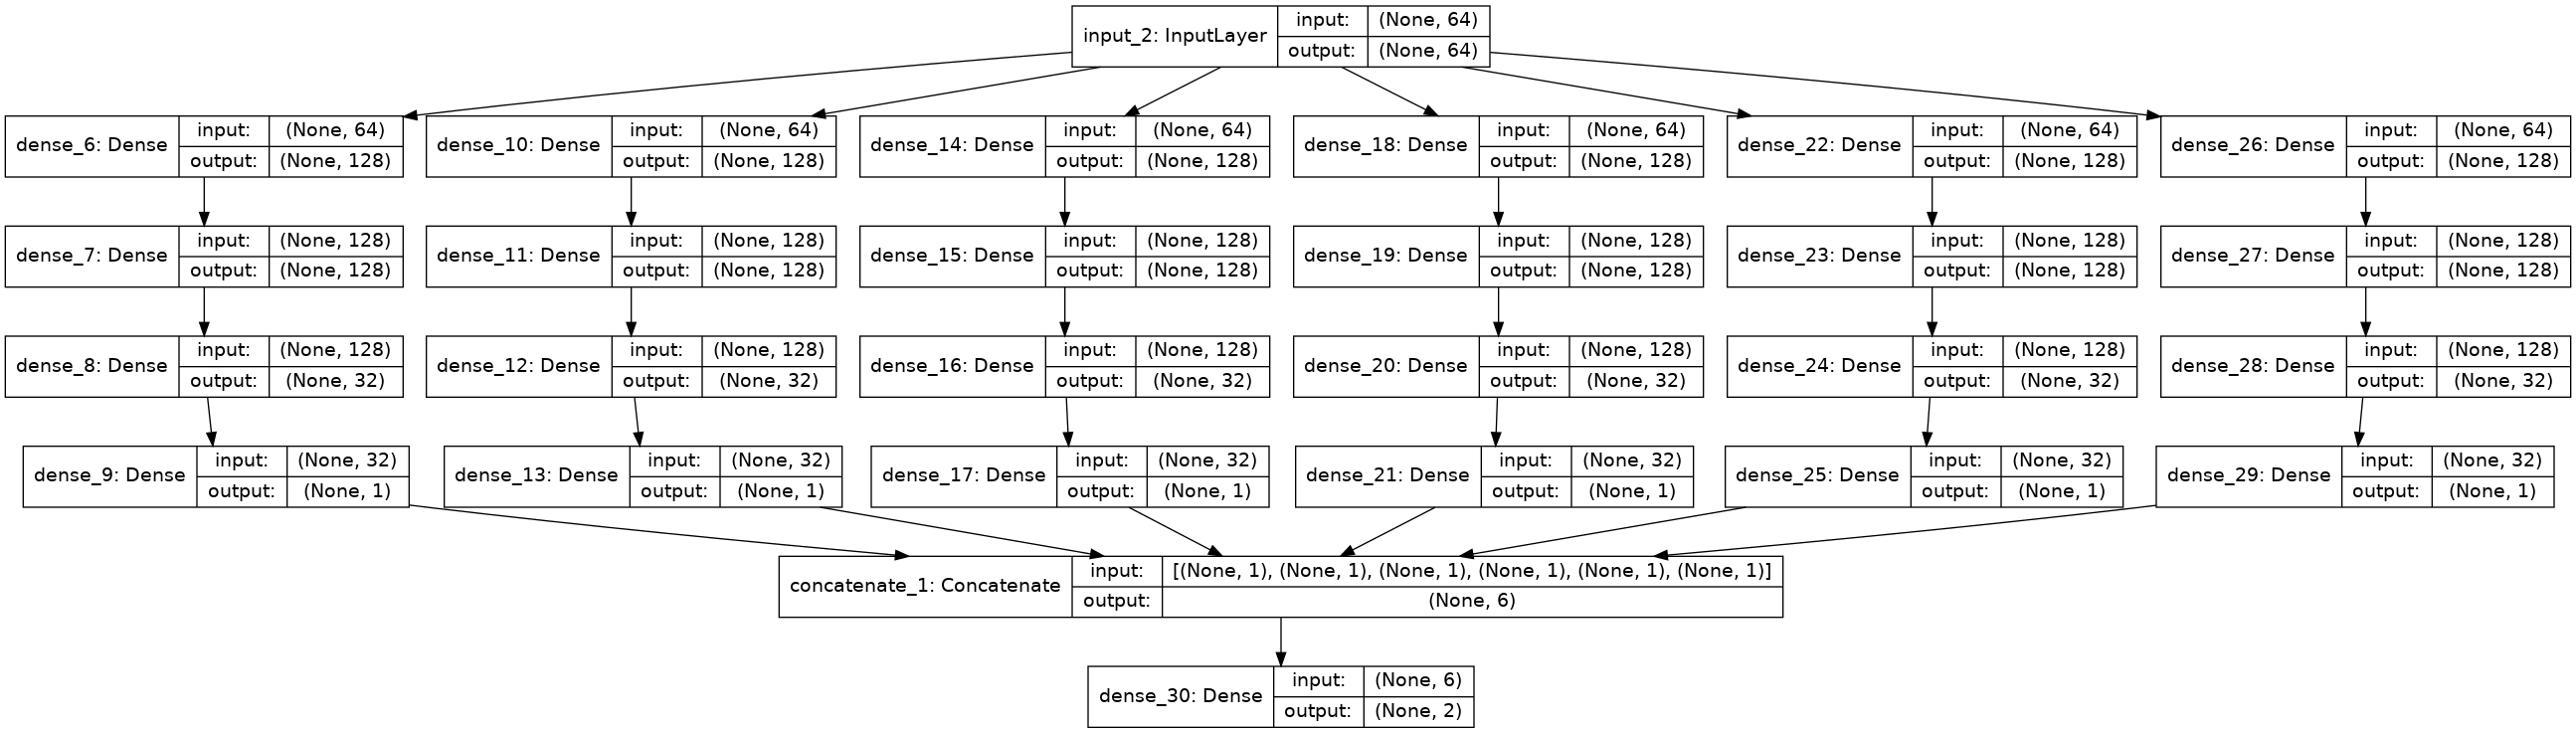

In [47]:
Image("model.png")

In [48]:
model2.fit(x=X_train, y=y_train, 
          batch_size=1000, epochs=2, verbose=1,
         validation_data=(X_test, y_test))

Train on 750000 samples, validate on 250000 samples
Epoch 1/2
750000/750000 [==============================] - 187s 249us/step - loss: 0.1625 - acc: 0.9697 - val_loss: 0.0544 - val_acc: 0.9908
Epoch 2/2
750000/750000 [==============================] - 181s 241us/step - loss: 0.0375 - acc: 0.9923 - val_loss: 0.0288 - val_acc: 0.9925


The assumption about training time was correct : it takes about 6 minutes to complete, which is 3 times more than the first one. The accuracy has improved, getting to 99.25%, which is 0.35% more than the first one on test set. Now we have obtained a fairly simple model that can give us pretty good accuracies, and a much more complex network that takes almost 3 times more to train, but gives slightly better results. Which one would someone choose? This is a question that remains to be answered till future work. 

In [87]:
# accuracy for first 10 000 samples from test set
n_test = 10000
sum(np.argmax(model1.predict(X_test[:n_test]),1) == np.argmax(y_test[:n_test],1)) / n_test

0.9911